예제 8.2 변형 오토 인코더

In [ ]:
# 예제 8.2 VAE 변형 오토 인코더

#셋업
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Layer
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 데이터셋 준비
(x_train, _), (_, _) = mnist.load_data()   # 레이블/테스트 데이터는 사용하지 않음

# 데이터 정규화
x_train = x_train / 255.

# 2차원 영상을 3차원으로 변환
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

print(x_train.shape)

(60000, 28, 28, 1)


In [ ]:
# 인코더 정의
latent_dim = 2

inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, kernel_size=3, strides=2, padding='same',
           activation='relu')(inputs)
x = Conv2D(64, kernel_size=3, strides=2, padding='same',
           activation='relu')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
mu = Dense(latent_dim)(x)
log_var = Dense(latent_dim)(x)

encoder = Model(inputs, [mu, log_var])

In [ ]:
# 잠재 공간 샘플링 계층 정의
class Sampling(Layer):
    def call(self, mu, log_var):
        epsilon = tf.random.normal(tf.shape(log_var))
        return mu + tf.exp(0.5 * log_var) * epsilon

In [ ]:
# 디코더 정의
decoder_inputs = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same',
                    activation='relu')(x)
x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same',
                    activation='relu')(x)
outputs = Conv2D(1, kernel_size=3, strides=1, padding='same',
                 activation='sigmoid')(x)

decoder = Model(decoder_inputs, outputs)

In [ ]:
# 변형 오토 인코더 정의
mu, log_var = encoder(inputs)
z = Sampling()(mu, log_var)
reconstruction = decoder(z)

# 모델 생성
model = Model(inputs, reconstruction)

In [ ]:
# 모델 컴파일
latent_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.exp(log_var)   # 잠재 손실
                                   - tf.square(mu), axis=-1)
latent_loss = tf.reduce_mean(latent_loss) / 784   # 픽셀 당 잠재 손실
model.add_loss(latent_loss)   # 손실 = 재구성 손실(출력, 정답) + 잠재 손실

model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# 모델 학습
history = model.fit(x_train, x_train, epochs=10, batch_size=32, verbose=0)

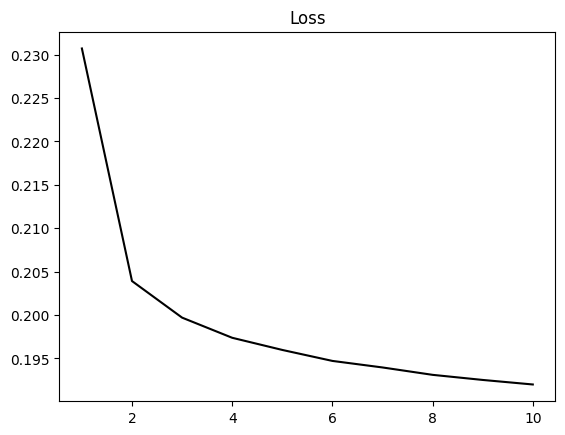

In [ ]:
# 학습 결과 시각화
plt.plot(range(1, len(history.history['loss']) + 1),
         history.history['loss'], color='black')
plt.title('Loss')

plt.show()

In [ ]:
# 이미지 생성
n = 100   # 이미지 수

generated_images = []
for i in range(n):
    latent_point = np.random.normal(size=(1, 2))   # 잠재 공간의 점
    decoded_image = decoder.predict(latent_point)
    image = decoded_image[0].reshape(28, 28)
    generated_images.append(image)

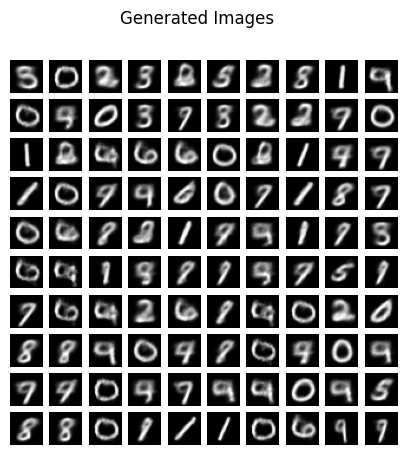

In [ ]:
# 생성 이미지 시각화
plt.figure(figsize=(5, 5))
plt.suptitle('Generated Images')

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')

plt.show()